In [1]:
import numpy as np
import torch
import torch.nn as nn
import seaborn as sns
import pandas as pd
import time
import matplotlib.pyplot as plt
from addict import Dict as Adict
import optuna
from deeptime.data import sqrt_model
from celerity.models import VAMPnetEstimator, HedgeVAMPNetEstimator, VAMPNetModel
from functools import partial


from deeptime.util.data import TrajectoryDataset
from deeptime.util.torch import MLP
from deeptime.decomposition.deep import VAMPNet
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

from deeptime.decomposition.deep import vampnet_loss


In [2]:
def plot_method(transform, score, score_std, traj, dtraj,  figsize=(6, 6)):
    r""" Plotting method for the different models.

    Parameters
    ----------
    transform : Callable
        Function pointer that projects data into a one-dimensional space.
    score
        VAMP-2 score
    score_std
        VAMP-2 score standard deviation
    """
    from deeptime.clustering import KMeans
    from matplotlib.colors import Normalize

    feat = transform(traj)
    
    feat_cc = KMeans(2).fit_transform(feat)

    xmax = np.max(np.abs(traj[:, 0]))
    ymin = np.min(traj[:, 1])
    ymax = np.max(traj[:, 1])
    vmin = np.min(feat)
    vmax = np.max(feat)
    vmag = np.max([np.abs(vmin), np.abs(vmax)])

    scatter_size = 35

    grid = np.meshgrid(np.linspace(-xmax-1, xmax+1, 500), np.linspace(ymin-1, ymax+1, 500))
    xy = np.dstack(grid).reshape(-1, 2)
    levels = np.linspace(0, vmag, num=5)

    z = np.concatenate([transform(xxyy) for xxyy in np.array_split(xy, 3)])
    z00 = transform(np.array([0, -1]).reshape(-1, 2))
    z = np.clip(z, vmin, vmax)

    if np.mean(np.abs((feat_cc[:500].squeeze() - dtraj[:500]))) > .3:
        feat_cc = 1. - feat_cc
    if z00 < 0:
        z *= -1.
    z *= -1

    cmap = 'BrBG'
    f = plt.figure(figsize=figsize, constrained_layout=True)
    height_ratios = [2, 1]
    gs = f.add_gridspec(2, 1, height_ratios=height_ratios)

    ax = f.add_subplot(gs[0, 0])
    ax_contour = ax

    norm = Normalize(-vmag, vmag)
    levels_fine = np.linspace(0, levels[1], num=5)
    levels = np.concatenate([-levels[2:][::-1], -levels_fine[1:][::-1], levels_fine, levels[2:]])

    cb = ax.contourf(grid[0], grid[1], z.reshape(grid[0].shape), levels=levels,
                     cmap=cmap, norm=norm, extend='both')

    ticks = levels
    cb = f.colorbar(cb, ax=ax, ticks=ticks[1::3])
    cb.ax.set_yticklabels([f"{x:.2f}" for x in ticks[1::3]])

    ix_0 = np.where((feat_cc == 0) & (feat_cc == dtraj))[0]
    ix_1 = np.where((feat_cc == 1) & (feat_cc == dtraj))[0]

    ax.scatter(*traj[ix_0].T,
               color=plt.cm.plasma(.3),
               s=scatter_size, linewidths=.1,
               marker='o', cmap=cmap, edgecolors='black',
               zorder=500, alpha=.5, label=f'Estimated state {0}')
    ax.scatter(*traj[ix_1].T,
               color=plt.cm.plasma(.8),
               s=scatter_size, linewidths=.1,
               marker='o', cmap=cmap, edgecolors='black',
               zorder=500, alpha=.5, label=f'Estimated state {1}')

    ix_0 = np.where((feat_cc == 0) & (feat_cc != dtraj))[0]
    ix_1 = np.where((feat_cc == 1) & (feat_cc != dtraj))[0]

    if len(ix_0) > 0:
        ax.scatter(*traj[ix_0].T,
                   color=plt.cm.plasma(.3),
                   s=scatter_size, linewidths=.5,
                   marker='o', cmap=cmap, edgecolors='red',
                   zorder=500, alpha=.5)
    if len(ix_1) > 0:
        ax.scatter(*traj[ix_1].T,
               color=plt.cm.plasma(.8),
               s=scatter_size, linewidths=.5,
               marker='o', cmap=cmap, edgecolors='red',
               zorder=500, alpha=.5)

    ax.legend()

    props = dict(boxstyle='square', facecolor='white', alpha=.8)
    ax.text(0.5, 0.08, r"$s={:.2f}\pm {:.2f}$".format(score, score_std), transform=ax.transAxes,
            verticalalignment='top', horizontalalignment='center', bbox=props, fontsize='x-small')

    ax = f.add_subplot(gs[1, 0])
    n_proj = 200
    mismatch = 100. * float(np.count_nonzero(feat_cc - dtraj)) / float(len(dtraj))
    rescaled_proj = .5*(feat[:n_proj] + 1)
    feat_cc = feat_cc[:n_proj]
    if np.mean(np.abs((rescaled_proj.squeeze() - dtraj[:n_proj]))) > .4:
        rescaled_proj = 1. - rescaled_proj
    xs = np.arange(len(rescaled_proj))
    ax.plot(xs, rescaled_proj, alpha=.3, color='C0')
    ax.plot(xs, feat_cc, color='C0', label=r'Estimated (${:.1f}\%$ mismatch)'.format(mismatch))
    ax.plot(xs, dtraj[:n_proj], color='C1', linestyle='dotted', label='Ground truth')
    ax.set_xlabel('time (a.u.)')
    ax.set_ylabel(r'$\chi (x_t)$')
    ax.set_ylim([-.5, 1.5])
    ax.set_yticks([0, 1])
    ax.set_title(r"${:.1f}\%$ acc.".format(100-mismatch))
    ax.legend(loc="lower center", ncol=2, fontsize='xx-small')

    return ax_contour, ax

In [3]:
def define_batch_mod(trial, input_dim, output_dim, lag_time, n_epochs): 
    nn_config = Adict(
        hidden_layer_width=None, 
        input_dim=input_dim, 
        output_dim=output_dim,
        n_hidden_layers=None,
        lag_time = lag_time, 
        lr = None, 
        n_epochs = n_epochs,
        
        optimizer=torch.optim.Adam, 
        score = Adict(
              method='VAMP2', 
              mode='regularize', 
              epsilon=1e-6
        ), 
        loss = vampnet_loss, 
        device="cpu"
    ) 
    
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    hidden_layer_width = trial.suggest_int("width", 2, 50)
    n_hidden_layers = trial.suggest_int("depth", 1, 10)
    
    nn_config.hidden_layer_width = hidden_layer_width
    nn_config.lr = learning_rate
    nn_config.n_hidden_layers = n_hidden_layers
    
    return nn_config
    
    
def define_online_mod(trial, input_dim, output_dim, lag_time): 
    nn_config = Adict(
        hidden_layer_width=None, 
        input_dim=input_dim, 
        output_dim=output_dim,
        n_hidden_layers=None,
        loss = partial(vampnet_loss, method='VAMP2', mode='regularize', epsilon=1e-6 ), 
        device="cpu", 
        b=None, 
        n=None,
        s=1e-8
    ) 
    
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    hidden_layer_width = trial.suggest_int("width", 2, 50)
    n_hidden_layers = 10 # trial.suggest_int("depth", 1, 10)
    expert_learning_rate = trial.suggest_float("export_learning_rate", 0.5, 1-1e-8)

    nn_config.hidden_layer_width = hidden_layer_width
    nn_config.n = learning_rate
    nn_config.n_hidden_layers = n_hidden_layers
    nn_config.b = expert_learning_rate
    
    return nn_config


def fit_online(est, loader, n_epochs, return_alphas): 
    est.train()
    alpha_dfs = []
    for i in range(n_epochs): 
        for j, batch in enumerate(loader): 
            est.partial_fit(batch)
            if return_alphas:
                alphas = est.get_alphas()
                df = pd.DataFrame({'alphas': alphas, 'layer': np.arange(len(alphas))+1})
                df['i_batch'] = j
                df['i_epoch'] = i
                alpha_dfs.append(df)
                
    if return_alphas: 
        df = pd.concat(alpha_dfs)
        df.reset_index(inplace=True, drop=True)
        return est, df
    
    return est

    
def eval_online(est, loader): 
    est.eval()
    tmp = []
    for val in loader: 
        tmp.append(-est.predict(val))    
    return np.mean(tmp)

    
def _objective(trial, data, mod_type): 
    OUTPUT_DIM = 1
    N_EPOCHS=1
    LAG_TIME=1
    INPUT_DIM=2
    VAL_FRAC=0.3
    N_BOOT=50
    
    
    # batch_size_power = trial.suggest_int("batch_size_power", 6, 11)
    batch_size = 2**7 # int(2**batch_size_power)
    
    dataset = TrajectoryDataset(LAG_TIME, data.astype(np.float32))
    n_val = int(len(dataset)*VAL_FRAC)

    scores = []
    if mod_type == 'batch':
        nn_config = define_batch_mod(trial, INPUT_DIM, OUTPUT_DIM, LAG_TIME, N_EPOCHS)        
    elif mod_type == 'online': 
        nn_config = define_online_mod(trial, INPUT_DIM, OUTPUT_DIM, LAG_TIME)    
    else: 
        raise NotImplementedError('model type not recognised')
        
    train_data, val_data = torch.utils.data.random_split(dataset, [len(dataset) - n_val, n_val])
    
    for _ in range(N_BOOT):
        sampler = torch.utils.data.RandomSampler(train_data, replacement=True)
        loader_train = DataLoader(train_data, batch_size=batch_size, sampler=sampler)

        loader_val = DataLoader(val_data, batch_size=len(val_data), shuffle=False)
    
        if mod_type == 'batch':
            est = VAMPnetEstimator(nn_config)
            est.fit(loader_train, loader_val)
            last_step = int(len(loader_train)*N_EPOCHS)
            
            score = est.dict_scores['validate']['VAMP2'][last_step]
            
        elif mod_type == 'online': 
            
            est = HedgeVAMPNetEstimator(**nn_config)
            est = fit_online(est, loader_train, N_EPOCHS)
            score = eval_online(est, loader_val)
            
        else: 
            raise NotImplementedError('model type not recognised')

        scores.append(score)
    return np.median(scores)


In [4]:
dtraj, traj = sqrt_model(n_samples=10000)

np.unique(dtraj, return_counts=True)

(array([0, 1], dtype=int32), array([5266, 4734]))

In [5]:
trials = pd.read_hdf('sqrt.h5', key='online')
trials.sort_values(by='value', ascending=False).head()

,number,value,datetime_start,datetime_complete,duration,params_export_learning_rate,params_learning_rate,params_width,state
53,53,1.638015,2022-09-26 15:39:10.323186,2022-09-26 15:40:07.527663,0 days 00:00:57.204477,0.523811,0.010562,45,COMPLETE
51,51,1.629497,2022-09-26 15:37:26.863612,2022-09-26 15:38:18.649755,0 days 00:00:51.786143,0.583420,0.010991,37,COMPLETE
21,21,1.615728,2022-09-26 15:12:48.721108,2022-09-26 15:13:41.696670,0 days 00:00:52.975562,0.501369,0.004365,34,COMPLETE
97,97,1.608280,2022-09-26 16:17:19.308673,2022-09-26 16:18:18.564918,0 days 00:00:59.256245,0.586010,0.001686,48,COMPLETE
90,90,1.607781,2022-09-26 16:11:35.694066,2022-09-26 16:12:21.790042,0 days 00:00:46.095976,0.613899,0.012442,30,COMPLETE


In [6]:
nn_config = Adict(
        hidden_layer_width=45, 
        input_dim=2, 
        output_dim=1,
        n_hidden_layers=10,
        loss = partial(vampnet_loss, method='VAMP2', mode='regularize', epsilon=1e-6 ), 
        device="cpu", 
        b=0.52, 
        n=0.01,
        s=1e-8
    ) 
batch_size = 2**7

N_EPOCHS=1
LAG_TIME=1
VAL_FRAC=0.3
N_BOOT = 100

data = traj

dataset = TrajectoryDataset(LAG_TIME, data.astype(np.float32))
n_val = int(len(dataset)*VAL_FRAC)

train_data, val_data = torch.utils.data.random_split(dataset, [len(dataset) - n_val, n_val])
sampler = torch.utils.data.RandomSampler(train_data, replacement=True)
loader_train = DataLoader(train_data, batch_size=batch_size, sampler=sampler)
loader_val = DataLoader(val_data, batch_size=len(val_data), shuffle=False)


In [7]:
all_dfs = []
ave_scores = []
alpha_dfs = []

for i in range(N_BOOT): 

    est = HedgeVAMPNetEstimator(**nn_config)
    est, alphas = fit_online(est, loader_train, N_EPOCHS, return_alphas = True)
    alphas['i_boot'] = i
    
    alpha_dfs.append(alphas)
    
    X = list(loader_val)[0]

    est.eval()
    predictions_per_layer = est.forward(X)
    loss_per_layer = est.loss_per_layer(predictions_per_layer)
    score_per_layer = np.array([-x.detach().cpu().numpy() for x in loss_per_layer])
    ave_score = est.predict(X)
    
    df = pd.DataFrame({'score': score_per_layer, 'layer': np.arange(len(score_per_layer))+1, 'weights': est.get_alphas()})
    df['iteration'] = i
    all_dfs.append(df)
    ave_scores.append(ave_score)
    

/Users/robertarbon/opt/miniconda3/envs/vampnets/lib/python3.8/site-packages/deeptime/decomposition/deep/_vampnet.py:42: UserWarning: torch.symeig is deprecated in favor of torch.linalg.eigh and will be removed in a future PyTorch release.
The default behavior has changed from using the upper triangular portion of the matrix by default to using the lower triangular portion.
L, _ = torch.symeig(A, upper=upper)
should be replaced with
L = torch.linalg.eigvalsh(A, UPLO='U' if upper else 'L')
and
L, V = torch.symeig(A, eigenvectors=True)
should be replaced with
L, V = torch.linalg.eigh(A, UPLO='U' if upper else 'L') (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1631631227379/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2500.)
  eigval, eigvec = torch.symeig(mat, eigenvectors=True)
/Users/robertarbon/opt/miniconda3/envs/vampnets/lib/python3.8/site-packages/torch/functional.py:1403: UserWarning: torch.chain_matmul is deprecated and will be removed in a future 

In [8]:
df = pd.concat(all_dfs)
df.reset_index(inplace=True, drop=True)

In [9]:
a_df = pd.concat(alpha_dfs)
a_df.reset_index(inplace=True, drop=True)
a_df.rename(columns=dict(i_batch = 'batch', alphas='weights'), inplace=True)


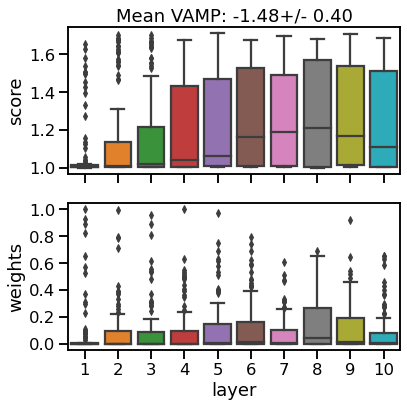

In [10]:
with sns.plotting_context('talk'): 
    fig, axes = plt.subplots(2, sharex=True, figsize=(6, 6))
#     ix_layer= np.arange(nn_config.n_hidden_layers)+1
#     ax = axes[0]
#     ax.bar(x=ix_layer, height=est.get_alphas())
    ax = axes[0]
    sns.boxplot(data=df, x='layer', y='score', ax=ax)
    # ax.set_ylabel('VAMP')
    ax.set_title(label=f"Mean VAMP: {np.mean(ave_scores):4.2f}+/- {2*np.std(ave_scores):4.2f}")
    ax.set_xlabel('')
    ax = axes[1]
    sns.boxplot(data=df, x='layer', y='weights', ax=ax)
    
    plt.tight_layout()
    
    plt.savefig('bootstrap_weight_vamps_per_layer.png', dpi=300, bbox_inches='tight')

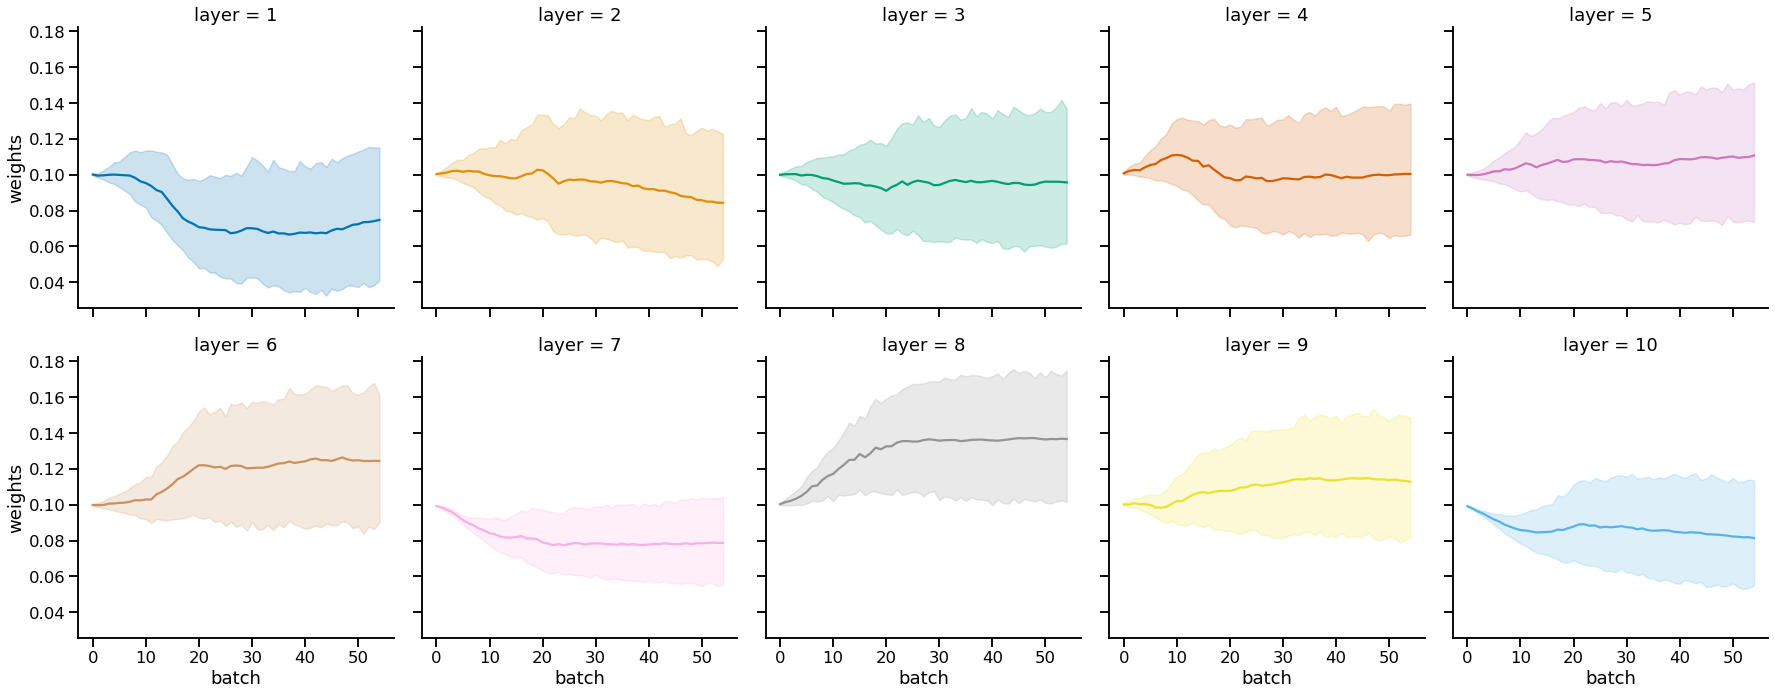

In [11]:
with sns.plotting_context('talk'): 
    sns.relplot(data=a_df.query('i_epoch==0'), x='batch', 
                y='weights', hue='layer',  kind='line', col='layer', col_wrap=5, palette='colorblind', 
                legend=False)
    plt.savefig('bootstrapped_weight_trajectories.png', dpi=300, bbox_inches='tight')

# Predictions

In [12]:
est = HedgeVAMPNetEstimator(**nn_config)
est, alphas = fit_online(est, loader_train, N_EPOCHS, return_alphas = True)

In [13]:
new_dtraj, new_traj = sqrt_model(n_samples=10000)


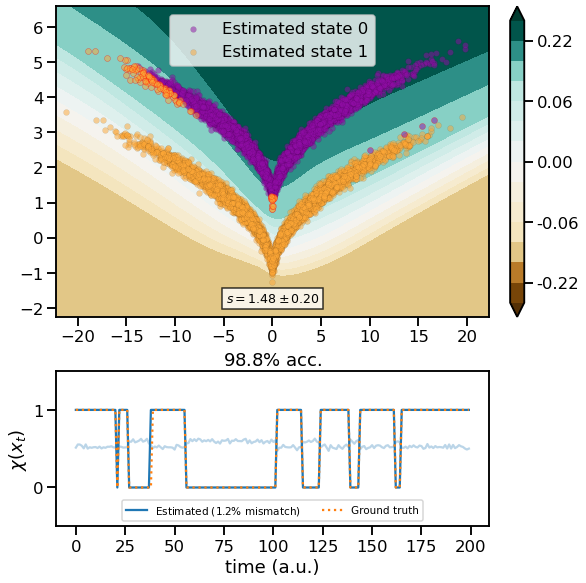

In [14]:
with sns.plotting_context('talk', font_scale=1): 
    def transform(x):
        return est.transform(torch.Tensor(x))

    plot_method(transform, -np.mean(ave_scores), np.std(ave_scores), new_traj, new_dtraj,  figsize=(8, 8))
    
    plt.savefig('online_predictions.png', dpi=300, bbox_inches='tight')

##  Batch model - with online architecture

In [15]:
nn_config_batch = Adict(
    hidden_layer_width=nn_config.hidden_layer_width, 
    input_dim=nn_config.input_dim, 
    output_dim=nn_config.output_dim,
    n_hidden_layers=nn_config.n_hidden_layers,
    lag_time = LAG_TIME, 
    lr = nn_config.n, 
    n_epochs = N_EPOCHS,

    optimizer=torch.optim.Adam, 
    score = Adict(
          method='VAMP2', 
          mode='regularize', 
          epsilon=1e-6
    ), 
    loss = vampnet_loss, 
    device="cpu"
) 

In [16]:
batch_ave_scores = []
for i in range(N_BOOT):
    print(i, end=', ')
    batch_est = VAMPnetEstimator(nn_config_batch)
    batch_est.fit(loader_train, loader_val)
    steps = list(batch_est.dict_scores['validate']['VAMP2'].keys())
    steps.sort()
    last_step = steps[-1]
    
    batch_ave_scores.append(batch_est.dict_scores['validate']['VAMP2'][last_step])

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 

Transform:   0%|          | 0/10000 [00:00<?, ?it/s]

Transform:   0%|          | 0/10000 [00:00<?, ?it/s]

Transform:   0%|          | 0/83334 [00:00<?, ?it/s]

Transform:   0%|          | 0/83333 [00:00<?, ?it/s]

Transform:   0%|          | 0/83333 [00:00<?, ?it/s]

Transform:   0%|          | 0/1 [00:00<?, ?it/s]

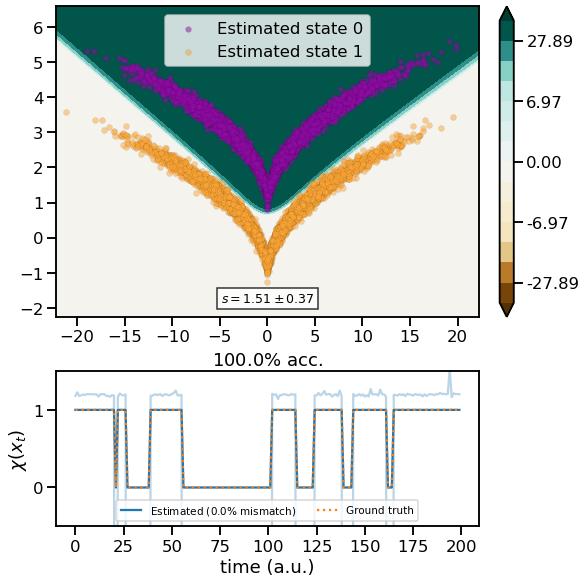

In [17]:
batch_mod = VAMPNetModel(dict(estimator=batch_est))

def transform(x):
    return np.concatenate(batch_mod.transform(torch.Tensor(x)))

transform(traj)

with sns.plotting_context('talk', font_scale=1): 


    plot_method(transform, np.mean(batch_ave_scores), np.std(batch_ave_scores) , new_traj, new_dtraj, figsize=(8, 8))
    
    plt.savefig('batch_predictions_online_config.png', dpi=300, bbox_inches='tight')

## Batch model - best archicture

In [18]:
trials = pd.read_hdf('sqrt.h5', key='batch')
trials.sort_values(by='value', ascending=False).head()

,number,value,datetime_start,datetime_complete,duration,params_depth,params_learning_rate,params_width,state
76,76,1.822436,2022-09-25 20:01:29.299666,2022-09-25 20:01:39.083760,0 days 00:00:09.784094,7,0.007837,28,COMPLETE
97,97,1.815208,2022-09-25 20:04:59.215992,2022-09-25 20:05:09.137584,0 days 00:00:09.921592,10,0.011546,13,COMPLETE
96,96,1.812335,2022-09-25 20:04:48.186694,2022-09-25 20:04:59.196057,0 days 00:00:11.009363,10,0.009158,19,COMPLETE
67,67,1.811069,2022-09-25 20:00:07.004669,2022-09-25 20:00:16.372012,0 days 00:00:09.367343,8,0.021048,17,COMPLETE
74,74,1.803635,2022-09-25 20:01:09.950993,2022-09-25 20:01:19.180117,0 days 00:00:09.229124,7,0.009010,24,COMPLETE


In [19]:
nn_config_batch = Adict(
    hidden_layer_width=28, 
    input_dim=nn_config.input_dim, 
    output_dim=nn_config.output_dim,
    n_hidden_layers=7,
    lag_time = LAG_TIME, 
    lr = 0.008, 
    n_epochs = N_EPOCHS,

    optimizer=torch.optim.Adam, 
    score = Adict(
          method='VAMP2', 
          mode='regularize', 
          epsilon=1e-6
    ), 
    loss = vampnet_loss, 
    device="cpu"
) 

batch_ave_scores = []
for i in range(N_BOOT):
    print(i, end=', ')
    batch_est = VAMPnetEstimator(nn_config_batch)
    batch_est.fit(loader_train, loader_val)
    steps = list(batch_est.dict_scores['validate']['VAMP2'].keys())
    steps.sort()
    last_step = steps[-1]
    
    batch_ave_scores.append(batch_est.dict_scores['validate']['VAMP2'][last_step])

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 

Transform:   0%|          | 0/10000 [00:00<?, ?it/s]

Transform:   0%|          | 0/10000 [00:00<?, ?it/s]

Transform:   0%|          | 0/83334 [00:00<?, ?it/s]

Transform:   0%|          | 0/83333 [00:00<?, ?it/s]

Transform:   0%|          | 0/83333 [00:00<?, ?it/s]

Transform:   0%|          | 0/1 [00:00<?, ?it/s]

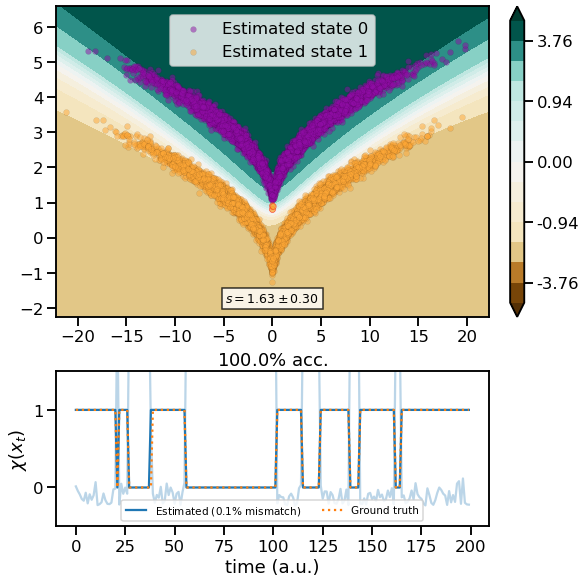

In [20]:
batch_mod = VAMPNetModel(dict(estimator=batch_est))

def transform(x):
    return np.concatenate(batch_mod.transform(torch.Tensor(x)))

transform(traj)

with sns.plotting_context('talk', font_scale=1): 


    plot_method(transform, np.mean(batch_ave_scores), np.std(batch_ave_scores) , new_traj, new_dtraj, figsize=(8, 8))
    
    plt.savefig('batch_predictions_best_config.png', dpi=300, bbox_inches='tight')